In [1]:
import pandas as pd

In [2]:
# Import packages
import tensorflow.compat.v1 as tf
# Disable the default activate eager execution in TF v1.0
tf.disable_eager_execution()
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from gensim.models import KeyedVectors
import re
import gensim

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aryuska/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
SAMPLE_USER=3

In [5]:
df_desc = pd.read_csv("./description-final.csv")

In [6]:
df_desc.columns = ["Title", "Description", "MovieID"]

In [7]:
movies_df = pd.read_csv('./ml-25m/movies.csv')
movies_df.columns = ["MovieID","Title","Genres"]

In [8]:
movies_df.shape

(62423, 3)

In [9]:
movies_df = pd.merge(movies_df, df_desc, on="MovieID", how="inner")

In [10]:
movies_df.head()

,MovieID,Title_x,Genres,Title_y,Description
0,99513,Waiting for Lightning (2012),Documentary,Waiting for Lightning,A documentary on pro skateboarder Danny Way's ...
1,99515,Yesterday's Enemy (1959),Drama|War,Yesterday's Enemy,"In World War II, during the Japanese invasion ..."
2,99517,Young People (1940),Drama,Young People,A show-business family leaves the Great White ...
3,99519,Henry (2010),Comedy,Henry,Henry is a cynical man who owns a musical inst...
4,99521,"Incruste, L' (a.k.a. L'Incruste, fallait pas l...",Comedy,L'incruste,A small crook manages to crash at a musician's...


In [12]:
#Loading in the ratings dataset
ratings_df = pd.read_csv('./ml-25m/ratings.csv')
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [13]:
# Rename the columns in the dataset
ratings_df.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']

In [14]:
# Create a separate indexing column as we cannot use MovieID
movies_df['List Index'] = movies_df.index

In [15]:
# Merge movies with ratings by MovieID as foreign key
merged_df = movies_df.merge(ratings_df, on='MovieID')

In [16]:
merged_df.head()

,MovieID,Title_x,Genres,Title_y,Description,List Index,UserID,Rating,Timestamp
0,99513,Waiting for Lightning (2012),Documentary,Waiting for Lightning,A documentary on pro skateboarder Danny Way's ...,0,31889,3.5,1479996552
1,99513,Waiting for Lightning (2012),Documentary,Waiting for Lightning,A documentary on pro skateboarder Danny Way's ...,0,40511,3.0,1504119072
2,99513,Waiting for Lightning (2012),Documentary,Waiting for Lightning,A documentary on pro skateboarder Danny Way's ...,0,63752,3.0,1495133656
3,99513,Waiting for Lightning (2012),Documentary,Waiting for Lightning,A documentary on pro skateboarder Danny Way's ...,0,72315,2.0,1455251735
4,99513,Waiting for Lightning (2012),Documentary,Waiting for Lightning,A documentary on pro skateboarder Danny Way's ...,0,75309,5.0,1558738197


In [17]:
# Drop columns
merged_df = merged_df.drop(['Title_x','Timestamp','Genres'], axis=1)

In [18]:
merged_df

,MovieID,Title_y,Description,List Index,UserID,Rating
0,99513,Waiting for Lightning,A documentary on pro skateboarder Danny Way's ...,0,31889,3.5
1,99513,Waiting for Lightning,A documentary on pro skateboarder Danny Way's ...,0,40511,3.0
2,99513,Waiting for Lightning,A documentary on pro skateboarder Danny Way's ...,0,63752,3.0
3,99513,Waiting for Lightning,A documentary on pro skateboarder Danny Way's ...,0,72315,2.0
4,99513,Waiting for Lightning,A documentary on pro skateboarder Danny Way's ...,0,75309,5.0
...,...,...,...,...,...,...
1699841,209157,Wij,Eight teens - four guys and four girls - are t...,43322,119571,1.5
1699842,209159,Janela da Alma,Nineteen people with differing degrees of visu...,43323,115835,3.0
1699843,209163,Rossz versek,"33-years old Tamás Merthner is heartbroken, af...",43324,6964,4.5
1699844,209169,A Girl Thing,An NYC shrink sees four different women with d...,43325,119571,3.0


In [23]:
merged_df = merged_df.sort_values(by='UserID',ascending=True)

In [24]:
# Get user groups
userGroup = merged_df.groupby('UserID')

In [26]:
def preprocess_data(userGroup, movies_df):
    # No. of users in training
    UsedUsers = 2500
    # create list
    trX = []
    # for each user in the group
    for userID, curUser in userGroup:
        # Temp variable that stores every movie's rating
        temp = [0] * len(movies_df)
        # For Each movie in the curUser's movie list
        for num, movie in curUser.iterrows():
            # Divide ratings by 5 and store it
            temp[int(movie['List Index'])] = movie['Rating'] / 5

        # Now add the list of ratings into the training list
        trX.append(temp)
        # Check to see if we finished adding in the amount of users for training
        if UsedUsers == 0:
            break
        UsedUsers -= 1
    return trX

In [27]:
# Return normalized user ratings into a list
trX = preprocess_data(userGroup, movies_df)

In [29]:
def rbm(movies_df):
    n_hid = 100  # Number of hidden layers
    n_vis = len(movies_df)  # Number of visible layers

    # Create respective placeholder variables for storing visible and hidden layer biases and weights
    vb = tf.placeholder("float", [n_vis])  # Number of unique movies
    hb = tf.placeholder("float", [n_hid])  # Number of features
    W = tf.placeholder("float", [n_vis, n_hid])  # Weights that connect the hidden and visible layers

    # Pre-process the input data
    v0 = tf.placeholder("float", [None, n_vis])
    _h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
    h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))

    # Reconstruct the pre-processed input data (Sigmoid and ReLU activation functions are used)
    _v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb)
    v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
    h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

    # Set RBM training parameters
    alpha = 0.1  # Set learning rate
    w_pos_grad = tf.matmul(tf.transpose(v0), h0)  # Set positive gradients
    w_neg_grad = tf.matmul(tf.transpose(v1), h1)  # Set negative gradients

    # Calculate contrastive divergence to maximize
    CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])

    # Create methods to update the weights and biases
    update_w = W + alpha * CD
    update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
    update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

    # Set error function (RMSE)
    err = v0 - v1
    err_sum = tf.sqrt(tf.reduce_mean(err**2))

    # Initialize variables
    cur_w = np.zeros([n_vis, n_hid], np.float32)  # Current weight
    cur_vb = np.zeros([n_vis], np.float32)  # Current visible unit biases
    cur_hb = np.zeros([n_hid], np.float32)  # Current hidden unit biases
    prv_w = np.zeros([n_vis, n_hid], np.float32)  # Previous weight
    prv_vb = np.zeros([n_vis], np.float32)  # Previous visible unit biases
    prv_hb = np.zeros([n_hid], np.float32)  # Previous hidden unit biases

    return v0, W, vb, hb, update_w, prv_w, prv_vb, prv_hb, update_vb, update_hb, cur_w, cur_vb, cur_hb, err_sum

In [30]:
# Return variables from the RBM implementation
v0, W, vb, hb, update_w, prv_w, prv_vb, prv_hb, update_vb, update_hb, cur_w, cur_vb, cur_hb, err_sum = rbm(movies_df)

Instructions for updating:
Use `tf.cast` instead.


In [31]:
# Initialize TensorFlow session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Train RBM with 50 epochs and batches of size 512
nb_epoch = 50
batch_size_ = 512
errors = []

2023-03-19 01:37:46.465337: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-03-19 01:37:46.477346: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [32]:
for i in range(nb_epoch):
    print("Current epoch: ", i)
    for start, end in zip(range(0, len(trX), batch_size_), range(batch_size_, len(trX), batch_size_)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
    errors.append(sess.run(err_sum, feed_dict={v0: trX, W: cur_w, vb: cur_vb, hb: cur_hb}))
    print("Current RMSE error: ", errors[-1])

Current epoch:  0
Current RMSE error:  0.47042966
Current epoch:  1
Current RMSE error:  0.4092551
Current epoch:  2
Current RMSE error:  0.3475895
Current epoch:  3
Current RMSE error:  0.3014771
Current epoch:  4
Current RMSE error:  0.27527198
Current epoch:  5
Current RMSE error:  0.2617587
Current epoch:  6
Current RMSE error:  0.25449654
Current epoch:  7
Current RMSE error:  0.25090516
Current epoch:  8
Current RMSE error:  0.24851437
Current epoch:  9
Current RMSE error:  0.24704991
Current epoch:  10
Current RMSE error:  0.23131569
Current epoch:  11
Current RMSE error:  0.20436887
Current epoch:  12
Current RMSE error:  0.17744395
Current epoch:  13
Current RMSE error:  0.15678887
Current epoch:  14
Current RMSE error:  0.1402933
Current epoch:  15
Current RMSE error:  0.12648797
Current epoch:  16
Current RMSE error:  0.115487784
Current epoch:  17
Current RMSE error:  0.10611067
Current epoch:  18
Current RMSE error:  0.0985828
Current epoch:  19
Current RMSE error:  0.0926

Text(0.5, 0, 'Number of Epochs')

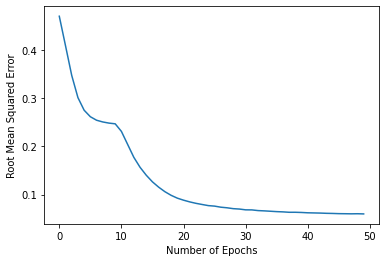

In [33]:
plt.plot(errors)
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Number of Epochs')

In [32]:
len(trX)

2501

In [34]:
# Selecting the input user
inputUser = [trX[SAMPLE_USER]]

In [35]:
# Feed in the user and reconstructing the input
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={hh0: feed, W: prv_w, vb: prv_vb})

In [36]:
# We can then list the 100 most recommended movies for our mock user by sorting it by their scores given by our model
scored_movies_df_1 = movies_df
scored_movies_df_1["Recommendation Score"] = rec[0]
print("\n")
scored_movies_df_1 = scored_movies_df_1.drop(['Title_x'],axis=1)
scored_movies_df_1.columns = ['MovieID', 'Genres', 'Title','Description','ListIndex','Recommendation Score']
scored_movies_df_1.sort_values(["Recommendation Score"], ascending=False)
rbm_rec_result = scored_movies_df_1.head(100)


In [37]:
scored_movies_df_1.shape

(43327, 6)

In [ ]:
#predicted rating

In [38]:
# Now we can find all the movies that our mock user has watched before
movies_df_1 = merged_df[merged_df['UserID'] == SAMPLE_USER]
movies_df_1

,MovieID,Title_y,Description,List Index,UserID,Rating
633226,115617,Big Hero 6,A special bond develops between plus-sized inf...,3476,3,4.0
486227,112138,22 Jump Street,After making their way through high school (tw...,2658,3,3.0
106460,103141,Monsters University,A look at the relationship between Mike Wazows...,774,3,3.5
234868,106002,Ender's Game,Young Ender Wiggin is recruited by the Interna...,1396,3,4.0
1498742,176371,Blade Runner 2049,Young Blade Runner K's discovery of a long-bur...,29206,3,4.5
...,...,...,...,...,...,...
1260112,158966,Captain Fantastic,"In the forests of the Pacific Northwest, a fat...",21144,3,3.5
646189,115713,Ex Machina,A young programmer is selected to participate ...,3499,3,4.5
1012453,135143,Fantastic Beasts and Where to Find Them,The adventures of writer Newt Scamander in New...,10866,3,3.5
376739,109487,Interstellar,A team of explorers travel through a wormhole ...,2103,3,4.0


In [39]:
userItemProfile = movies_df_1.merge(scored_movies_df_1, on="MovieID", how="inner")

In [40]:
userItemProfile=userItemProfile.drop(['Title_y', 'Description_x','List Index'],axis=1)

In [41]:
userItemProfile

,MovieID,UserID,Rating,Genres,Title,Description_y,ListIndex,Recommendation Score
0,115617,3,4.0,Action|Animation|Comedy,Big Hero 6,A special bond develops between plus-sized inf...,3476,0.191547
1,112138,3,3.0,Action|Comedy|Crime,22 Jump Street,After making their way through high school (tw...,2658,0.055491
2,103141,3,3.5,Adventure|Animation|Comedy,Monsters University,A look at the relationship between Mike Wazows...,774,0.065561
3,106002,3,4.0,Action|Adventure|Sci-Fi|IMAX,Ender's Game,Young Ender Wiggin is recruited by the Interna...,1396,0.060374
4,176371,3,4.5,Sci-Fi,Blade Runner 2049,Young Blade Runner K's discovery of a long-bur...,29206,0.074047
...,...,...,...,...,...,...,...,...
110,158966,3,3.5,Drama,Captain Fantastic,"In the forests of the Pacific Northwest, a fat...",21144,0.029247
111,115713,3,4.5,Drama|Sci-Fi|Thriller,Ex Machina,A young programmer is selected to participate ...,3499,0.208193
112,135143,3,3.5,Fantasy,Fantastic Beasts and Where to Find Them,The adventures of writer Newt Scamander in New...,10866,0.090938
113,109487,3,4.0,Sci-Fi|IMAX,Interstellar,A team of explorers travel through a wormhole ...,2103,0.703620


In [42]:
userItemProfile.columns = ['MovieID','UserID','Rating','Genres','Title','Description','List Index', 'Recommendation Score']

In [43]:
userItemProfile

,MovieID,UserID,Rating,Genres,Title,Description,List Index,Recommendation Score
0,115617,3,4.0,Action|Animation|Comedy,Big Hero 6,A special bond develops between plus-sized inf...,3476,0.191547
1,112138,3,3.0,Action|Comedy|Crime,22 Jump Street,After making their way through high school (tw...,2658,0.055491
2,103141,3,3.5,Adventure|Animation|Comedy,Monsters University,A look at the relationship between Mike Wazows...,774,0.065561
3,106002,3,4.0,Action|Adventure|Sci-Fi|IMAX,Ender's Game,Young Ender Wiggin is recruited by the Interna...,1396,0.060374
4,176371,3,4.5,Sci-Fi,Blade Runner 2049,Young Blade Runner K's discovery of a long-bur...,29206,0.074047
...,...,...,...,...,...,...,...,...
110,158966,3,3.5,Drama,Captain Fantastic,"In the forests of the Pacific Northwest, a fat...",21144,0.029247
111,115713,3,4.5,Drama|Sci-Fi|Thriller,Ex Machina,A young programmer is selected to participate ...,3499,0.208193
112,135143,3,3.5,Fantasy,Fantastic Beasts and Where to Find Them,The adventures of writer Newt Scamander in New...,10866,0.090938
113,109487,3,4.0,Sci-Fi|IMAX,Interstellar,A team of explorers travel through a wormhole ...,2103,0.703620


In [44]:
# We merge all the movies that our mock users has watched with the predicted scores based on his historical data
merged_df_1 = scored_movies_df_1.merge(movies_df_1, on='MovieID', how='outer')
print("\n")
merged_df_1.sort_values(["Recommendation Score"], ascending=False).head(25)


,MovieID,Genres,Title,Description_x,ListIndex,Recommendation Score,Title_y,Description_y,List Index,UserID,Rating
2103,109487,Sci-Fi|IMAX,Interstellar,A team of explorers travel through a wormhole ...,2103,0.703620,Interstellar,A team of explorers travel through a wormhole ...,2103.0,3.0,4.0
2840,112852,Action|Adventure|Sci-Fi,Guardians of the Galaxy,A group of intergalactic criminals must pull t...,2840,0.353315,Guardians of the Galaxy,A group of intergalactic criminals must pull t...,2840.0,3.0,4.0
5967,122904,Action|Adventure|Comedy|Sci-Fi,Deadpool,A wisecracking mercenary gets experimented on ...,5967,0.273018,NaN,NaN,NaN,NaN,NaN
10754,134853,Adventure|Animation|Children|Comedy|Drama|Fantasy,Inside Out,After young Riley is uprooted from her Midwest...,10754,0.262666,Inside Out,After young Riley is uprooted from her Midwest...,10754.0,3.0,4.0
3915,116797,Drama|Thriller|War,The Imitation Game,"During World War II, the English mathematical ...",3915,0.248500,The Imitation Game,"During World War II, the English mathematical ...",3915.0,3.0,4.0
2595,111759,Action|Sci-Fi|IMAX,Edge of Tomorrow,A soldier fighting aliens gets to relive the s...,2595,0.244740,Edge of Tomorrow,A soldier fighting aliens gets to relive the s...,2595.0,3.0,4.0
2761,112552,Drama,Whiplash,A promising young drummer enrolls at a cut-thr...,2761,0.236599,Whiplash,A promising young drummer enrolls at a cut-thr...,2761.0,3.0,5.0
5957,122882,Action|Adventure|Sci-Fi|Thriller,Mad Max: Fury Road,"In a post-apocalyptic wasteland, a woman rebel...",5957,0.226171,Mad Max: Fury Road,"In a post-apocalyptic wasteland, a woman rebel...",5957.0,3.0,3.5
2071,109374,Comedy|Drama,The Grand Budapest Hotel,A writer encounters the owner of an aging high...,2071,0.225015,The Grand Budapest Hotel,A writer encounters the owner of an aging high...,2071.0,3.0,4.0
1555,106782,Comedy|Crime|Drama,The Wolf of Wall Street,"Based on the true story of Jordan Belfort, fro...",1555,0.208340,The Wolf of Wall Street,"Based on the true story of Jordan Belfort, fro...",1555.0,3.0,4.5


In [45]:
merged_df_1.shape

(43327, 11)

In [46]:
userItemProfile

,MovieID,UserID,Rating,Genres,Title,Description,List Index,Recommendation Score
0,115617,3,4.0,Action|Animation|Comedy,Big Hero 6,A special bond develops between plus-sized inf...,3476,0.191547
1,112138,3,3.0,Action|Comedy|Crime,22 Jump Street,After making their way through high school (tw...,2658,0.055491
2,103141,3,3.5,Adventure|Animation|Comedy,Monsters University,A look at the relationship between Mike Wazows...,774,0.065561
3,106002,3,4.0,Action|Adventure|Sci-Fi|IMAX,Ender's Game,Young Ender Wiggin is recruited by the Interna...,1396,0.060374
4,176371,3,4.5,Sci-Fi,Blade Runner 2049,Young Blade Runner K's discovery of a long-bur...,29206,0.074047
...,...,...,...,...,...,...,...,...
110,158966,3,3.5,Drama,Captain Fantastic,"In the forests of the Pacific Northwest, a fat...",21144,0.029247
111,115713,3,4.5,Drama|Sci-Fi|Thriller,Ex Machina,A young programmer is selected to participate ...,3499,0.208193
112,135143,3,3.5,Fantasy,Fantastic Beasts and Where to Find Them,The adventures of writer Newt Scamander in New...,10866,0.090938
113,109487,3,4.0,Sci-Fi|IMAX,Interstellar,A team of explorers travel through a wormhole ...,2103,0.703620


In [47]:
merged_df_1.sort_values(by='Rating', ascending=False)

,MovieID,Genres,Title,Description_x,ListIndex,Recommendation Score,Title_y,Description_y,List Index,UserID,Rating
11410,136449,Action|Animation|Sci-Fi,Kôkaku kidôtai 2.0,A hacker known as the Puppet Master is hunted ...,11410,0.011435,Kôkaku kidôtai 2.0,A hacker known as the Puppet Master is hunted ...,11410.0,3.0,5.0
2763,112556,Drama|Thriller,Gone Girl,With his wife's disappearance having become th...,2763,0.099705,Gone Girl,With his wife's disappearance having become th...,2763.0,3.0,5.0
2761,112552,Drama,Whiplash,A promising young drummer enrolls at a cut-thr...,2761,0.236599,Whiplash,A promising young drummer enrolls at a cut-thr...,2761.0,3.0,5.0
3499,115713,Drama|Sci-Fi|Thriller,Ex Machina,A young programmer is selected to participate ...,3499,0.208193,Ex Machina,A young programmer is selected to participate ...,3499.0,3.0,4.5
1022,104243,Action|Sci-Fi|Thriller|IMAX,Riddick,"Left for dead on a sun-scorched planet, Riddic...",1022,0.032189,Riddick,"Left for dead on a sun-scorched planet, Riddic...",1022.0,3.0,4.5
...,...,...,...,...,...,...,...,...,...,...,...
43322,209157,Drama,Wij,Eight teens - four guys and four girls - are t...,43322,0.000828,NaN,NaN,NaN,NaN,NaN
43323,209159,Documentary,Janela da Alma,Nineteen people with differing degrees of visu...,43323,0.000800,NaN,NaN,NaN,NaN,NaN
43324,209163,Comedy|Drama,Rossz versek,"33-years old Tamás Merthner is heartbroken, af...",43324,0.000907,NaN,NaN,NaN,NaN,NaN
43325,209169,(no genres listed),A Girl Thing,An NYC shrink sees four different women with d...,43325,0.000808,NaN,NaN,NaN,NaN,NaN


In [48]:
merged_df_1

,MovieID,Genres,Title,Description_x,ListIndex,Recommendation Score,Title_y,Description_y,List Index,UserID,Rating
0,99513,Documentary,Waiting for Lightning,A documentary on pro skateboarder Danny Way's ...,0,0.000743,NaN,NaN,NaN,NaN,NaN
1,99515,Drama|War,Yesterday's Enemy,"In World War II, during the Japanese invasion ...",1,0.000895,NaN,NaN,NaN,NaN,NaN
2,99517,Drama,Young People,A show-business family leaves the Great White ...,2,0.000860,NaN,NaN,NaN,NaN,NaN
3,99519,Comedy,Henry,Henry is a cynical man who owns a musical inst...,3,0.000795,NaN,NaN,NaN,NaN,NaN
4,99521,Comedy,L'incruste,A small crook manages to crash at a musician's...,4,0.000822,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
43322,209157,Drama,Wij,Eight teens - four guys and four girls - are t...,43322,0.000828,NaN,NaN,NaN,NaN,NaN
43323,209159,Documentary,Janela da Alma,Nineteen people with differing degrees of visu...,43323,0.000800,NaN,NaN,NaN,NaN,NaN
43324,209163,Comedy|Drama,Rossz versek,"33-years old Tamás Merthner is heartbroken, af...",43324,0.000907,NaN,NaN,NaN,NaN,NaN
43325,209169,(no genres listed),A Girl Thing,An NYC shrink sees four different women with d...,43325,0.000808,NaN,NaN,NaN,NaN,NaN


In [49]:
rbm_result = merged_df_1

In [50]:
rbm_result

,MovieID,Genres,Title,Description_x,ListIndex,Recommendation Score,Title_y,Description_y,List Index,UserID,Rating
0,99513,Documentary,Waiting for Lightning,A documentary on pro skateboarder Danny Way's ...,0,0.000743,NaN,NaN,NaN,NaN,NaN
1,99515,Drama|War,Yesterday's Enemy,"In World War II, during the Japanese invasion ...",1,0.000895,NaN,NaN,NaN,NaN,NaN
2,99517,Drama,Young People,A show-business family leaves the Great White ...,2,0.000860,NaN,NaN,NaN,NaN,NaN
3,99519,Comedy,Henry,Henry is a cynical man who owns a musical inst...,3,0.000795,NaN,NaN,NaN,NaN,NaN
4,99521,Comedy,L'incruste,A small crook manages to crash at a musician's...,4,0.000822,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
43322,209157,Drama,Wij,Eight teens - four guys and four girls - are t...,43322,0.000828,NaN,NaN,NaN,NaN,NaN
43323,209159,Documentary,Janela da Alma,Nineteen people with differing degrees of visu...,43323,0.000800,NaN,NaN,NaN,NaN,NaN
43324,209163,Comedy|Drama,Rossz versek,"33-years old Tamás Merthner is heartbroken, af...",43324,0.000907,NaN,NaN,NaN,NaN,NaN
43325,209169,(no genres listed),A Girl Thing,An NYC shrink sees four different women with d...,43325,0.000808,NaN,NaN,NaN,NaN,NaN


In [51]:
rbm_result['UserID'] = rbm_result['UserID'].fillna(3)

In [52]:
rbm_result

,MovieID,Genres,Title,Description_x,ListIndex,Recommendation Score,Title_y,Description_y,List Index,UserID,Rating
0,99513,Documentary,Waiting for Lightning,A documentary on pro skateboarder Danny Way's ...,0,0.000743,NaN,NaN,NaN,3.0,NaN
1,99515,Drama|War,Yesterday's Enemy,"In World War II, during the Japanese invasion ...",1,0.000895,NaN,NaN,NaN,3.0,NaN
2,99517,Drama,Young People,A show-business family leaves the Great White ...,2,0.000860,NaN,NaN,NaN,3.0,NaN
3,99519,Comedy,Henry,Henry is a cynical man who owns a musical inst...,3,0.000795,NaN,NaN,NaN,3.0,NaN
4,99521,Comedy,L'incruste,A small crook manages to crash at a musician's...,4,0.000822,NaN,NaN,NaN,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
43322,209157,Drama,Wij,Eight teens - four guys and four girls - are t...,43322,0.000828,NaN,NaN,NaN,3.0,NaN
43323,209159,Documentary,Janela da Alma,Nineteen people with differing degrees of visu...,43323,0.000800,NaN,NaN,NaN,3.0,NaN
43324,209163,Comedy|Drama,Rossz versek,"33-years old Tamás Merthner is heartbroken, af...",43324,0.000907,NaN,NaN,NaN,3.0,NaN
43325,209169,(no genres listed),A Girl Thing,An NYC shrink sees four different women with d...,43325,0.000808,NaN,NaN,NaN,3.0,NaN


In [53]:
userItemProfile = userItemProfile.sort_values(by='Rating', ascending=False)
userItemProfile = userItemProfile[userItemProfile['Rating'] >= 3.5]
userItemProfile

,MovieID,UserID,Rating,Genres,Title,Description,List Index,Recommendation Score
36,112552,3,5.0,Drama,Whiplash,A promising young drummer enrolls at a cut-thr...,2761,0.236599
83,112556,3,5.0,Drama|Thriller,Gone Girl,With his wife's disappearance having become th...,2763,0.099705
17,136449,3,5.0,Action|Animation|Sci-Fi,Kôkaku kidôtai 2.0,A hacker known as the Puppet Master is hunted ...,11410,0.011435
90,104243,3,4.5,Action|Sci-Fi|Thriller|IMAX,Riddick,"Left for dead on a sun-scorched planet, Riddic...",1022,0.032189
111,115713,3,4.5,Drama|Sci-Fi|Thriller,Ex Machina,A young programmer is selected to participate ...,3499,0.208193
...,...,...,...,...,...,...,...,...
26,111443,3,3.5,Comedy,Chef,A head chef quits his restaurant job and buys ...,2524,0.019357
71,136020,3,3.5,Action|Adventure|Crime,Spectre,A cryptic message from James Bond's past sends...,11254,0.042370
27,103384,3,3.5,Action|Adventure|Western|IMAX,The Lone Ranger,Native American warrior Tonto recounts the unt...,832,0.020990
68,110407,3,3.5,Sci-Fi|Thriller,The Machine,In efforts to construct perfect android killin...,2327,0.003493


In [54]:
df_cbf = merged_df_1[merged_df_1.isna().any(axis=1)]
df_cbf=df_cbf.drop('Rating', axis=1)

In [55]:
df_cbf = df_cbf.sort_values(by='Recommendation Score', ascending=False).head(20)

In [164]:
df_cbf = df_cbf.sort_values(by='Recommendation Score', ascending=False)

In [56]:
df_cbf

,MovieID,Genres,Title,Description_x,ListIndex,Recommendation Score,Title_y,Description_y,List Index,UserID
5967,122904,Action|Adventure|Comedy|Sci-Fi,Deadpool,A wisecracking mercenary gets experimented on ...,5967,0.273018,NaN,NaN,NaN,3.0
4648,119145,Action|Adventure|Comedy|Crime,Kingsman: The Secret Service,A spy organisation recruits a promising street...,4648,0.149578,NaN,NaN,NaN,3.0
18088,152081,Action|Adventure|Animation|Children|Comedy,Zootopia,"In a city of anthropomorphic animals, a rookie...",18088,0.132968,NaN,NaN,NaN,3.0
8016,128360,Western,The Hateful Eight,"In the dead of a Wyoming winter, a bounty hunt...",8016,0.123049,NaN,NaN,NaN,3.0
2663,112183,Comedy|Drama,Birdman or (The Unexpected Virtue of Ignorance),A washed-up superhero actor attempts to revive...,2663,0.120500,NaN,NaN,NaN,3.0
1542,106696,Adventure|Animation|Comedy|Fantasy|Musical|Rom...,Frozen,When the newly crowned Queen Elsa accidentally...,1542,0.116063,NaN,NaN,NaN,3.0
3389,115149,Action|Thriller,John Wick,An ex-hit-man comes out of retirement to track...,3389,0.107932,NaN,NaN,NaN,3.0
5973,122916,Action|Adventure|Sci-Fi,Thor: Ragnarok,"Imprisoned on the planet Sakaar, Thor must rac...",5973,0.102693,NaN,NaN,NaN,3.0
29781,177593,Crime|Drama,"Three Billboards Outside Ebbing, Missouri",A mother personally challenges the local autho...,29781,0.089968,NaN,NaN,NaN,3.0
1160,104879,Drama|Mystery|Thriller,Prisoners,When Keller Dover's daughter and her friend go...,1160,0.089739,NaN,NaN,NaN,3.0


In [57]:
df_cbf=df_cbf.drop(['List Index','UserID', 'Description_y', 'Title_y'],axis=1)
df_cbf

,MovieID,Genres,Title,Description_x,ListIndex,Recommendation Score
5967,122904,Action|Adventure|Comedy|Sci-Fi,Deadpool,A wisecracking mercenary gets experimented on ...,5967,0.273018
4648,119145,Action|Adventure|Comedy|Crime,Kingsman: The Secret Service,A spy organisation recruits a promising street...,4648,0.149578
18088,152081,Action|Adventure|Animation|Children|Comedy,Zootopia,"In a city of anthropomorphic animals, a rookie...",18088,0.132968
8016,128360,Western,The Hateful Eight,"In the dead of a Wyoming winter, a bounty hunt...",8016,0.123049
2663,112183,Comedy|Drama,Birdman or (The Unexpected Virtue of Ignorance),A washed-up superhero actor attempts to revive...,2663,0.120500
1542,106696,Adventure|Animation|Comedy|Fantasy|Musical|Rom...,Frozen,When the newly crowned Queen Elsa accidentally...,1542,0.116063
3389,115149,Action|Thriller,John Wick,An ex-hit-man comes out of retirement to track...,3389,0.107932
5973,122916,Action|Adventure|Sci-Fi,Thor: Ragnarok,"Imprisoned on the planet Sakaar, Thor must rac...",5973,0.102693
29781,177593,Crime|Drama,"Three Billboards Outside Ebbing, Missouri",A mother personally challenges the local autho...,29781,0.089968
1160,104879,Drama|Mystery|Thriller,Prisoners,When Keller Dover's daughter and her friend go...,1160,0.089739


In [58]:
df_cbf.columns = ['MovieID','Genres','Title','Description','List Index', 'Recommendation Score']
df_cbf

,MovieID,Genres,Title,Description,List Index,Recommendation Score
5967,122904,Action|Adventure|Comedy|Sci-Fi,Deadpool,A wisecracking mercenary gets experimented on ...,5967,0.273018
4648,119145,Action|Adventure|Comedy|Crime,Kingsman: The Secret Service,A spy organisation recruits a promising street...,4648,0.149578
18088,152081,Action|Adventure|Animation|Children|Comedy,Zootopia,"In a city of anthropomorphic animals, a rookie...",18088,0.132968
8016,128360,Western,The Hateful Eight,"In the dead of a Wyoming winter, a bounty hunt...",8016,0.123049
2663,112183,Comedy|Drama,Birdman or (The Unexpected Virtue of Ignorance),A washed-up superhero actor attempts to revive...,2663,0.120500
1542,106696,Adventure|Animation|Comedy|Fantasy|Musical|Rom...,Frozen,When the newly crowned Queen Elsa accidentally...,1542,0.116063
3389,115149,Action|Thriller,John Wick,An ex-hit-man comes out of retirement to track...,3389,0.107932
5973,122916,Action|Adventure|Sci-Fi,Thor: Ragnarok,"Imprisoned on the planet Sakaar, Thor must rac...",5973,0.102693
29781,177593,Crime|Drama,"Three Billboards Outside Ebbing, Missouri",A mother personally challenges the local autho...,29781,0.089968
1160,104879,Drama|Mystery|Thriller,Prisoners,When Keller Dover's daughter and her friend go...,1160,0.089739


In [59]:
print(df_cbf['Description'].isna().sum())

0


In [60]:
df_cbf = df_cbf.dropna(subset=['Description'])

In [61]:
print(df_cbf['Description'].isna().sum())

0


In [62]:

def _removeNonAscii(s):
    return "".join(i.encode('ascii', 'ignore').decode() for i in s )

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [63]:
df_cbf['Cleaned'] = df_cbf['Description'].apply(_removeNonAscii)

df_cbf['Cleaned'] = df_cbf.Cleaned.apply(func = make_lower_case)
df_cbf['Cleaned'] = df_cbf.Cleaned.apply(func = remove_stop_words)
df_cbf['Cleaned'] = df_cbf.Cleaned.apply(func=remove_punctuation)
df_cbf['Cleaned'] = df_cbf.Cleaned.apply(func=remove_html)


In [64]:
userItemProfile['Cleaned'] = userItemProfile['Description'].apply(_removeNonAscii)

userItemProfile['Cleaned'] = userItemProfile.Cleaned.apply(func = make_lower_case)
userItemProfile['Cleaned'] = userItemProfile.Cleaned.apply(func = remove_stop_words)
userItemProfile['Cleaned'] = userItemProfile.Cleaned.apply(func=remove_punctuation)
userItemProfile['Cleaned'] = userItemProfile.Cleaned.apply(func=remove_html)

In [65]:
corpusCBF = []
for words in df_cbf['Cleaned']:
    corpusCBF.append(words.split())


In [66]:
model = gensim.models.Word2Vec(corpusCBF, min_count=1)

In [67]:
user_pref = ""
for i,data in userItemProfile.iterrows():
    user_pref += " " + data['Cleaned']

In [68]:
print(user_pref)

 promising young drummer enrolls cut throat music conservatory dreams greatness mentored instructor stop nothing realize student s potential wife s disappearance become focus intense media circus man sees spotlight turned suspected may innocent hacker known puppet master hunted female cyborg cop partner film revised version kkaku kidtai 1995 left dead sun scorched planet riddick finds alien race predators activating emergency beacon alerts two ships one carrying new breed mercenary captained man riddick s past young programmer selected participate ground breaking experiment synthetic intelligence evaluating human qualities highly advanced humanoid a i young blade runner k s discovery long buried secret leads track former blade runner rick deckard who s missing thirty years based true story jordan belfort rise wealthy stock broker living high life fall involving crime corruption federal government foul mouthed mutant mercenary wade wilson a k a deadpool assembles team fellow mutant rogu

In [69]:
corpus_user_pref = []
corpus_user_pref.append(user_pref.split())

In [70]:
corpus_user_pref[0]

['promising',
 'young',
 'drummer',
 'enrolls',
 'cut',
 'throat',
 'music',
 'conservatory',
 'dreams',
 'greatness',
 'mentored',
 'instructor',
 'stop',
 'nothing',
 'realize',
 'student',
 's',
 'potential',
 'wife',
 's',
 'disappearance',
 'become',
 'focus',
 'intense',
 'media',
 'circus',
 'man',
 'sees',
 'spotlight',
 'turned',
 'suspected',
 'may',
 'innocent',
 'hacker',
 'known',
 'puppet',
 'master',
 'hunted',
 'female',
 'cyborg',
 'cop',
 'partner',
 'film',
 'revised',
 'version',
 'kkaku',
 'kidtai',
 '1995',
 'left',
 'dead',
 'sun',
 'scorched',
 'planet',
 'riddick',
 'finds',
 'alien',
 'race',
 'predators',
 'activating',
 'emergency',
 'beacon',
 'alerts',
 'two',
 'ships',
 'one',
 'carrying',
 'new',
 'breed',
 'mercenary',
 'captained',
 'man',
 'riddick',
 's',
 'past',
 'young',
 'programmer',
 'selected',
 'participate',
 'ground',
 'breaking',
 'experiment',
 'synthetic',
 'intelligence',
 'evaluating',
 'human',
 'qualities',
 'highly',
 'advanced',
 '

In [71]:
df_cbf

,MovieID,Genres,Title,Description,List Index,Recommendation Score,Cleaned
5967,122904,Action|Adventure|Comedy|Sci-Fi,Deadpool,A wisecracking mercenary gets experimented on ...,5967,0.273018,wisecracking mercenary gets experimented becom...
4648,119145,Action|Adventure|Comedy|Crime,Kingsman: The Secret Service,A spy organisation recruits a promising street...,4648,0.149578,spy organisation recruits promising street kid...
18088,152081,Action|Adventure|Animation|Children|Comedy,Zootopia,"In a city of anthropomorphic animals, a rookie...",18088,0.132968,city anthropomorphic animals rookie bunny cop ...
8016,128360,Western,The Hateful Eight,"In the dead of a Wyoming winter, a bounty hunt...",8016,0.123049,dead wyoming winter bounty hunter prisoner fin...
2663,112183,Comedy|Drama,Birdman or (The Unexpected Virtue of Ignorance),A washed-up superhero actor attempts to revive...,2663,0.120500,washed up superhero actor attempts revive fadi...
1542,106696,Adventure|Animation|Comedy|Fantasy|Musical|Rom...,Frozen,When the newly crowned Queen Elsa accidentally...,1542,0.116063,newly crowned queen elsa accidentally uses pow...
3389,115149,Action|Thriller,John Wick,An ex-hit-man comes out of retirement to track...,3389,0.107932,ex hit man comes retirement track gangsters ki...
5973,122916,Action|Adventure|Sci-Fi,Thor: Ragnarok,"Imprisoned on the planet Sakaar, Thor must rac...",5973,0.102693,imprisoned planet sakaar thor must race time r...
29781,177593,Crime|Drama,"Three Billboards Outside Ebbing, Missouri",A mother personally challenges the local autho...,29781,0.089968,mother personally challenges local authorities...
1160,104879,Drama|Mystery|Thriller,Prisoners,When Keller Dover's daughter and her friend go...,1160,0.089739,keller dover s daughter friend go missing take...


In [72]:
def get_similarity_score(text):
    return model.wv.n_similarity(corpus_user_pref[0], text.split())

In [73]:
df_cbf = df_cbf.sort_values(by='Recommendation Score', ascending=False).head(100)
df_cbf

,MovieID,Genres,Title,Description,List Index,Recommendation Score,Cleaned
5967,122904,Action|Adventure|Comedy|Sci-Fi,Deadpool,A wisecracking mercenary gets experimented on ...,5967,0.273018,wisecracking mercenary gets experimented becom...
4648,119145,Action|Adventure|Comedy|Crime,Kingsman: The Secret Service,A spy organisation recruits a promising street...,4648,0.149578,spy organisation recruits promising street kid...
18088,152081,Action|Adventure|Animation|Children|Comedy,Zootopia,"In a city of anthropomorphic animals, a rookie...",18088,0.132968,city anthropomorphic animals rookie bunny cop ...
8016,128360,Western,The Hateful Eight,"In the dead of a Wyoming winter, a bounty hunt...",8016,0.123049,dead wyoming winter bounty hunter prisoner fin...
2663,112183,Comedy|Drama,Birdman or (The Unexpected Virtue of Ignorance),A washed-up superhero actor attempts to revive...,2663,0.120500,washed up superhero actor attempts revive fadi...
1542,106696,Adventure|Animation|Comedy|Fantasy|Musical|Rom...,Frozen,When the newly crowned Queen Elsa accidentally...,1542,0.116063,newly crowned queen elsa accidentally uses pow...
3389,115149,Action|Thriller,John Wick,An ex-hit-man comes out of retirement to track...,3389,0.107932,ex hit man comes retirement track gangsters ki...
5973,122916,Action|Adventure|Sci-Fi,Thor: Ragnarok,"Imprisoned on the planet Sakaar, Thor must rac...",5973,0.102693,imprisoned planet sakaar thor must race time r...
29781,177593,Crime|Drama,"Three Billboards Outside Ebbing, Missouri",A mother personally challenges the local autho...,29781,0.089968,mother personally challenges local authorities...
1160,104879,Drama|Mystery|Thriller,Prisoners,When Keller Dover's daughter and her friend go...,1160,0.089739,keller dover s daughter friend go missing take...


In [74]:
df_cbf['Similarity Score'] = df_cbf.Cleaned.apply(get_similarity_score)

In [75]:
df_cbf = df_cbf.sort_values(by='Similarity Score',ascending=False)

In [76]:
df_cbf

,MovieID,Genres,Title,Description,List Index,Recommendation Score,Cleaned,Similarity Score
5973,122916,Action|Adventure|Sci-Fi,Thor: Ragnarok,"Imprisoned on the planet Sakaar, Thor must rac...",5973,0.102693,imprisoned planet sakaar thor must race time r...,0.531031
24518,166461,Adventure|Animation|Children|Comedy|Fantasy,Moana,"In Ancient Polynesia, when a terrible curse in...",24518,0.082246,ancient polynesia terrible curse incurred demi...,0.302527
1364,105844,Drama,12 Years a Slave,"In the antebellum United States, Solomon North...",1364,0.074349,antebellum united states solomon northup free ...,0.283881
25353,168250,Horror,Get Out,A young African-American visits his white girl...,25353,0.070666,young african american visits white girlfriend...,0.282608
29781,177593,Crime|Drama,"Three Billboards Outside Ebbing, Missouri",A mother personally challenges the local autho...,29781,0.089968,mother personally challenges local authorities...,0.280830
4648,119145,Action|Adventure|Comedy|Crime,Kingsman: The Secret Service,A spy organisation recruits a promising street...,4648,0.149578,spy organisation recruits promising street kid...,0.269541
1054,104374,Drama|Fantasy|Romance,About Time,"At the age of 21, Tim discovers he can travel ...",1054,0.072446,age 21 tim discovers travel time change happen...,0.253269
1160,104879,Drama|Mystery|Thriller,Prisoners,When Keller Dover's daughter and her friend go...,1160,0.089739,keller dover s daughter friend go missing take...,0.237051
3389,115149,Action|Thriller,John Wick,An ex-hit-man comes out of retirement to track...,3389,0.107932,ex hit man comes retirement track gangsters ki...,0.225224
1301,105504,Adventure|Drama|Thriller|IMAX,Captain Phillips,The true story of Captain Richard Phillips and...,1301,0.075820,true story captain richard phillips 2009 hijac...,0.206090


In [77]:
avg_ratings = ratings_df.groupby('MovieID')['Rating'].mean()

In [78]:

movies_with_ratings = pd.merge(df_cbf, avg_ratings, on="MovieID", how="inner")

In [79]:
movies_with_ratings.columns= ['MovieID', 'Genres','Title','Description','List Index', 'Recommendation Score','Cleaned','Similarity Score', 'AVG Rating']

In [80]:
movies_with_ratings

,MovieID,Genres,Title,Description,List Index,Recommendation Score,Cleaned,Similarity Score,AVG Rating
0,122916,Action|Adventure|Sci-Fi,Thor: Ragnarok,"Imprisoned on the planet Sakaar, Thor must rac...",5973,0.102693,imprisoned planet sakaar thor must race time r...,0.531031,3.888957
1,166461,Adventure|Animation|Children|Comedy|Fantasy,Moana,"In Ancient Polynesia, when a terrible curse in...",24518,0.082246,ancient polynesia terrible curse incurred demi...,0.302527,3.849899
2,105844,Drama,12 Years a Slave,"In the antebellum United States, Solomon North...",1364,0.074349,antebellum united states solomon northup free ...,0.283881,3.883172
3,168250,Horror,Get Out,A young African-American visits his white girl...,25353,0.070666,young african american visits white girlfriend...,0.282608,3.962774
4,177593,Crime|Drama,"Three Billboards Outside Ebbing, Missouri",A mother personally challenges the local autho...,29781,0.089968,mother personally challenges local authorities...,0.280830,4.005391
5,119145,Action|Adventure|Comedy|Crime,Kingsman: The Secret Service,A spy organisation recruits a promising street...,4648,0.149578,spy organisation recruits promising street kid...,0.269541,3.798285
6,104374,Drama|Fantasy|Romance,About Time,"At the age of 21, Tim discovers he can travel ...",1054,0.072446,age 21 tim discovers travel time change happen...,0.253269,3.970379
7,104879,Drama|Mystery|Thriller,Prisoners,When Keller Dover's daughter and her friend go...,1160,0.089739,keller dover s daughter friend go missing take...,0.237051,3.992082
8,115149,Action|Thriller,John Wick,An ex-hit-man comes out of retirement to track...,3389,0.107932,ex hit man comes retirement track gangsters ki...,0.225224,3.795864
9,105504,Adventure|Drama|Thriller|IMAX,Captain Phillips,The true story of Captain Richard Phillips and...,1301,0.075820,true story captain richard phillips 2009 hijac...,0.206090,3.793845


In [81]:
train_ratings = ratings_df.sample(frac=0.8, random_state=1)
test_ratings = ratings_df.drop(train_ratings.index)

In [82]:
train_df = userItemProfile

In [83]:
user_means = train_ratings.groupby('UserID')['Rating'].mean()

In [84]:
train_ratings['Rating Adjusted'] = train_ratings['Rating'] - train_ratings['UserID'].map(user_means)

In [85]:
movie_weights = train_ratings.groupby('MovieID')['Rating Adjusted'].sum() / train_ratings.groupby('MovieID')['Rating Adjusted'].count()

In [ ]:
test_ratings['Predicted Rating'] = test_ratings.apply(lambda row: user_means.get(row['UserID'], 0) + movie_weights.get(row['MovieID'], 0), axis=1)

In [86]:
movies_with_ratings['UserID'] = 3

In [87]:
movies_with_ratings['Predicted Rating'] = movies_with_ratings.apply(lambda row: user_means.get(row['UserID'], 0) + movie_weights.get(row['MovieID'], 0), axis=1)

In [88]:
movies_with_ratings.head(1)

,MovieID,Genres,Title,Description,List Index,Recommendation Score,Cleaned,Similarity Score,AVG Rating,UserID,Predicted Rating
0,122916,Action|Adventure|Sci-Fi,Thor: Ragnarok,"Imprisoned on the planet Sakaar, Thor must rac...",5973,0.102693,imprisoned planet sakaar thor must race time r...,0.531031,3.888957,3,3.840556


In [89]:
def binRating(rating):
    if rating >= 3.5:
        return 1
    else:
        return 0

In [90]:
movies_with_ratings['BIN AVG Rating'] = movies_with_ratings['AVG Rating'].apply(binRating)
movies_with_ratings['BIN Predicted Rating'] = movies_with_ratings['Predicted Rating'].apply(binRating)

In [91]:
movies_with_ratings.head()

,MovieID,Genres,Title,Description,List Index,Recommendation Score,Cleaned,Similarity Score,AVG Rating,UserID,Predicted Rating,BIN AVG Rating,BIN Predicted Rating
0,122916,Action|Adventure|Sci-Fi,Thor: Ragnarok,"Imprisoned on the planet Sakaar, Thor must rac...",5973,0.102693,imprisoned planet sakaar thor must race time r...,0.531031,3.888957,3,3.840556,1,1
1,166461,Adventure|Animation|Children|Comedy|Fantasy,Moana,"In Ancient Polynesia, when a terrible curse in...",24518,0.082246,ancient polynesia terrible curse incurred demi...,0.302527,3.849899,3,3.845390,1,1
2,105844,Drama,12 Years a Slave,"In the antebellum United States, Solomon North...",1364,0.074349,antebellum united states solomon northup free ...,0.283881,3.883172,3,3.946500,1,1
3,168250,Horror,Get Out,A young African-American visits his white girl...,25353,0.070666,young african american visits white girlfriend...,0.282608,3.962774,3,3.991926,1,1
4,177593,Crime|Drama,"Three Billboards Outside Ebbing, Missouri",A mother personally challenges the local autho...,29781,0.089968,mother personally challenges local authorities...,0.280830,4.005391,3,4.027613,1,1


In [92]:

def precision_recall_at_k(recommended_items, relevant_items, k):
    """
    Calculate precision@k and recall@k for a recommendation system.
    
    Args:
    - recommended_items: list of recommended items
    - relevant_items: list of relevant items
    - k: integer, number of items to consider
    
    Returns:
    - precision@k: float, precision at k
    - recall@k: float, recall at k
    """
    
    recommended_items = recommended_items[:k]
    
    # Calculate precision@k
    precision = len(set(recommended_items).intersection(set(relevant_items))) / float(k)
    
    # Calculate recall@k
    recall = len(set(recommended_items).intersection(set(relevant_items))) / float(len(relevant_items))
    
    return precision, recall


In [93]:
k = 5
precision, recall = precision_recall_at_k(movies_with_ratings['BIN Predicted Rating'], movies_with_ratings['BIN AVG Rating'], k)

print('Precision@{}: {:.2f}'.format(k, precision))
print('Recall@{}: {:.2f}'.format(k, recall))

Precision@5: 0.20
Recall@5: 0.05


In [94]:
rbm_result['Predicted Rating'] = rbm_result.apply(lambda row: user_means.get(row['UserID'], 0) + movie_weights.get(row['MovieID'], 0), axis=1)

In [95]:

rbm_result = pd.merge(rbm_result, avg_ratings, on="MovieID", how="inner")

In [96]:
rbm_result.head(1)

,MovieID,Genres,Title,Description_x,ListIndex,Recommendation Score,Title_y,Description_y,List Index,UserID,Rating_x,Predicted Rating,Rating_y
0,99513,Documentary,Waiting for Lightning,A documentary on pro skateboarder Danny Way's ...,0,0.000743,NaN,NaN,NaN,3.0,NaN,3.128219,3.5


In [97]:
rbm_result = rbm_result.drop(['Title_y','Description_y', 'List Index', 'Rating_x'],axis=1)

In [98]:
rbm_result

,MovieID,Genres,Title,Description_x,ListIndex,Recommendation Score,UserID,Predicted Rating,Rating_y
0,99513,Documentary,Waiting for Lightning,A documentary on pro skateboarder Danny Way's ...,0,0.000743,3.0,3.128219,3.500000
1,99515,Drama|War,Yesterday's Enemy,"In World War II, during the Japanese invasion ...",1,0.000895,3.0,3.686567,4.250000
2,99517,Drama,Young People,A show-business family leaves the Great White ...,2,0.000860,3.0,3.454503,3.000000
3,99519,Comedy,Henry,Henry is a cynical man who owns a musical inst...,3,0.000795,3.0,2.173604,2.500000
4,99521,Comedy,L'incruste,A small crook manages to crash at a musician's...,4,0.000822,3.0,2.976858,2.666667
...,...,...,...,...,...,...,...,...,...
39987,209157,Drama,Wij,Eight teens - four guys and four girls - are t...,43322,0.000828,3.0,1.473801,1.500000
39988,209159,Documentary,Janela da Alma,Nineteen people with differing degrees of visu...,43323,0.000800,3.0,3.183981,3.000000
39989,209163,Comedy|Drama,Rossz versek,"33-years old Tamás Merthner is heartbroken, af...",43324,0.000907,3.0,4.642938,4.500000
39990,209169,(no genres listed),A Girl Thing,An NYC shrink sees four different women with d...,43325,0.000808,3.0,2.973801,3.000000


In [99]:
rbm_result.columns = ['MovieID','Genres','Title','Description', 'List Index', 'Recommendation Score', 'UserID','PredictedRating', 'AVG Rating']

In [100]:
rbm_result

,MovieID,Genres,Title,Description,List Index,Recommendation Score,UserID,PredictedRating,AVG Rating
0,99513,Documentary,Waiting for Lightning,A documentary on pro skateboarder Danny Way's ...,0,0.000743,3.0,3.128219,3.500000
1,99515,Drama|War,Yesterday's Enemy,"In World War II, during the Japanese invasion ...",1,0.000895,3.0,3.686567,4.250000
2,99517,Drama,Young People,A show-business family leaves the Great White ...,2,0.000860,3.0,3.454503,3.000000
3,99519,Comedy,Henry,Henry is a cynical man who owns a musical inst...,3,0.000795,3.0,2.173604,2.500000
4,99521,Comedy,L'incruste,A small crook manages to crash at a musician's...,4,0.000822,3.0,2.976858,2.666667
...,...,...,...,...,...,...,...,...,...
39987,209157,Drama,Wij,Eight teens - four guys and four girls - are t...,43322,0.000828,3.0,1.473801,1.500000
39988,209159,Documentary,Janela da Alma,Nineteen people with differing degrees of visu...,43323,0.000800,3.0,3.183981,3.000000
39989,209163,Comedy|Drama,Rossz versek,"33-years old Tamás Merthner is heartbroken, af...",43324,0.000907,3.0,4.642938,4.500000
39990,209169,(no genres listed),A Girl Thing,An NYC shrink sees four different women with d...,43325,0.000808,3.0,2.973801,3.000000


In [101]:
rbm_result['BIN Predicted Rating'] = rbm_result['PredictedRating'].apply(binRating)
rbm_result['BIN AVG Rating'] = rbm_result['AVG Rating'].apply(binRating)


In [102]:
rbm_result.shape

(39992, 11)

In [103]:
k = 5
precision, recall = precision_recall_at_k(rbm_result['BIN Predicted Rating'], rbm_result['BIN AVG Rating'], k)

print('Precision@{}: {:.2f}'.format(k, precision))
print('Recall@{}: {:.2f}'.format(k, recall))

Precision@5: 0.40
Recall@5: 0.00


In [137]:
movies_with_ratings['Relevant Score'] = 0.5 * movies_with_ratings['Recommendation Score'] + 0.5 * movies_with_ratings['Similarity Score']

In [138]:
movies_with_ratings = movies_with_ratings.sort_values('Relevant Score', ascending=False)
movies_with_ratings

,MovieID,Genres,Title,Description,List Index,Recommendation Score,Cleaned,Similarity Score,AVG Rating,UserID,Predicted Rating,BIN AVG Rating,BIN Predicted Rating,Relevant Score
0,122916,Action|Adventure|Sci-Fi,Thor: Ragnarok,"Imprisoned on the planet Sakaar, Thor must rac...",5973,0.102693,imprisoned planet sakaar thor must race time r...,0.531031,3.888957,3,3.840556,1,1,0.316862
5,119145,Action|Adventure|Comedy|Crime,Kingsman: The Secret Service,A spy organisation recruits a promising street...,4648,0.149578,spy organisation recruits promising street kid...,0.269541,3.798285,3,3.767625,1,1,0.209560
15,122904,Action|Adventure|Comedy|Sci-Fi,Deadpool,A wisecracking mercenary gets experimented on ...,5967,0.273018,wisecracking mercenary gets experimented becom...,0.129820,3.852662,3,3.797092,1,1,0.201419
1,166461,Adventure|Animation|Children|Comedy|Fantasy,Moana,"In Ancient Polynesia, when a terrible curse in...",24518,0.082246,ancient polynesia terrible curse incurred demi...,0.302527,3.849899,3,3.845390,1,1,0.192387
4,177593,Crime|Drama,"Three Billboards Outside Ebbing, Missouri",A mother personally challenges the local autho...,29781,0.089968,mother personally challenges local authorities...,0.280830,4.005391,3,4.027613,1,1,0.185399
2,105844,Drama,12 Years a Slave,"In the antebellum United States, Solomon North...",1364,0.074349,antebellum united states solomon northup free ...,0.283881,3.883172,3,3.946500,1,1,0.179115
3,168250,Horror,Get Out,A young African-American visits his white girl...,25353,0.070666,young african american visits white girlfriend...,0.282608,3.962774,3,3.991926,1,1,0.176637
8,115149,Action|Thriller,John Wick,An ex-hit-man comes out of retirement to track...,3389,0.107932,ex hit man comes retirement track gangsters ki...,0.225224,3.795864,3,3.823725,1,1,0.166578
7,104879,Drama|Mystery|Thriller,Prisoners,When Keller Dover's daughter and her friend go...,1160,0.089739,keller dover s daughter friend go missing take...,0.237051,3.992082,3,4.014391,1,1,0.163395
6,104374,Drama|Fantasy|Romance,About Time,"At the age of 21, Tim discovers he can travel ...",1054,0.072446,age 21 tim discovers travel time change happen...,0.253269,3.970379,3,3.987197,1,1,0.162858


In [139]:
def dcg_at_k(r, k):
    """
    Calculate DCG (Discounted Cumulative Gain) at k for a list of item ratings.
    
    Args:
    - r: list of item ratings
    - k: integer, number of items to consider
    
    Returns:
    - DCG@k: float, Discounted Cumulative Gain at k
    """
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.0

def ndcg_at_k(r, k):
    """
    Calculate NDCG (Normalized Discounted Cumulative Gain) at k for a list of item ratings.
    
    Args:
    - r: list of item ratings
    - k: integer, number of items to consider
    
    Returns:
    - NDCG@k: float, Normalized Discounted Cumulative Gain at k
    """
    dcg_max = dcg_at_k(sorted(r, reverse=True), k)
    if not dcg_max:
        return 0.0
    return dcg_at_k(r, k) / dcg_max


In [141]:
# ndcg hybrid
movies_with_ratings = movies_with_ratings.sort_values('Similarity Score', ascending=False)
item_ratings = movies_with_ratings['AVG Rating'] # item ratings in the ranked order
k = 5
ndcg = ndcg_at_k(item_ratings, k)

print('NDCG@{}: {:.2f}'.format(k, ndcg))

NDCG@5: 0.92


In [142]:
df_cbf = pd.merge(df_cbf, avg_ratings, on="MovieID", how="inner")

/var/folders/wp/36kdrjm51z92ythp0vp8xp5m0000gn/T/ipykernel_7933/1154607222.py:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Rating_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_cbf = pd.merge(df_cbf, avg_ratings, on="MovieID", how="inner")


In [143]:
movies_with_ratings

,MovieID,Genres,Title,Description,List Index,Recommendation Score,Cleaned,Similarity Score,AVG Rating,UserID,Predicted Rating,BIN AVG Rating,BIN Predicted Rating,Relevant Score
0,122916,Action|Adventure|Sci-Fi,Thor: Ragnarok,"Imprisoned on the planet Sakaar, Thor must rac...",5973,0.102693,imprisoned planet sakaar thor must race time r...,0.531031,3.888957,3,3.840556,1,1,0.316862
1,166461,Adventure|Animation|Children|Comedy|Fantasy,Moana,"In Ancient Polynesia, when a terrible curse in...",24518,0.082246,ancient polynesia terrible curse incurred demi...,0.302527,3.849899,3,3.845390,1,1,0.192387
2,105844,Drama,12 Years a Slave,"In the antebellum United States, Solomon North...",1364,0.074349,antebellum united states solomon northup free ...,0.283881,3.883172,3,3.946500,1,1,0.179115
3,168250,Horror,Get Out,A young African-American visits his white girl...,25353,0.070666,young african american visits white girlfriend...,0.282608,3.962774,3,3.991926,1,1,0.176637
4,177593,Crime|Drama,"Three Billboards Outside Ebbing, Missouri",A mother personally challenges the local autho...,29781,0.089968,mother personally challenges local authorities...,0.280830,4.005391,3,4.027613,1,1,0.185399
5,119145,Action|Adventure|Comedy|Crime,Kingsman: The Secret Service,A spy organisation recruits a promising street...,4648,0.149578,spy organisation recruits promising street kid...,0.269541,3.798285,3,3.767625,1,1,0.209560
6,104374,Drama|Fantasy|Romance,About Time,"At the age of 21, Tim discovers he can travel ...",1054,0.072446,age 21 tim discovers travel time change happen...,0.253269,3.970379,3,3.987197,1,1,0.162858
7,104879,Drama|Mystery|Thriller,Prisoners,When Keller Dover's daughter and her friend go...,1160,0.089739,keller dover s daughter friend go missing take...,0.237051,3.992082,3,4.014391,1,1,0.163395
8,115149,Action|Thriller,John Wick,An ex-hit-man comes out of retirement to track...,3389,0.107932,ex hit man comes retirement track gangsters ki...,0.225224,3.795864,3,3.823725,1,1,0.166578
9,105504,Adventure|Drama|Thriller|IMAX,Captain Phillips,The true story of Captain Richard Phillips and...,1301,0.075820,true story captain richard phillips 2009 hijac...,0.206090,3.793845,3,3.868791,1,1,0.140955


In [144]:
# ndcg rbm
movies_with_ratings = movies_with_ratings.sort_values('Recommendation Score', ascending=False)
item_ratings = movies_with_ratings['AVG Rating'] # item ratings in the ranked order
k = 5
ndcg = ndcg_at_k(item_ratings, k)

print('NDCG@{}: {:.2f}'.format(k, ndcg))

NDCG@5: 0.87
